# Capstone Project: The Persuasive Power of Words

*by Nee Bimin*

## Notebook 3: Model Selection

In this notebook, we will run a few models to select the production model for testing in the next notebook.

## Content

- [Read Data](#Read-Data)
- [Persuasive Classifier](#Persuasive-Words-Classifier)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Inspiring Classifier](#Persuasive-Words-Classifier)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Unconvincing Classifier](#Persuasive-Words-Classifier)
    * [Hyperparameter Tuning](#Hyperparameter-Tuning)
- [Binary Classifier Model Evaluation](#Binary-Classifier-Model-Evaluation)
    * [Preparing Unseen Data](#Preparing-Unseen-Data)
        * [Parsing Data](#Parsing-Data)
        * [Preprocessing](#Preprocessing)
    * [Persuasive Classifier Evaluation](#Persuasive-Classifier-Evaluation)
    * [Inspiring Classifier Evaluation](#Inspiring-Classifier-Evaluation)
    * [Unconvincing Classifier Evaluation](#Unconvincing-Classifier-Evaluation)
- [Multilabel Classifier](#Multilabel-Classifier)
    * [Train/Test Split](#Train/Test-Split)
    * [Linear SVC](#Linear-SVC)
    * [Naive Bayes](#Naive-Bayes)
    * [Logistic Regression](#Logistic-Regression)
- [Conclusion-and-Recommendations](#Conclusion)
    * [Production Model](#Production-Model)
    * [Top Coefficients](#Top-Coefficients)
    * [Limitations](#Limitations)
    * [Future Works](#Future-Works)

In [ ]:
# # Run line(s) to install the following
# !pip3 install joblib
# !pip3 install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Import libraries for modeling
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import joblib

# Import libraries for parsing html
import bs4 as bs 
import soupsieve as sv # Soup Sieve to parse using CSS selector
import codecs # To read in HTML file

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Read Data

In [3]:
# Read in data
ted_model = pd.read_csv('../data/ted_model_final.csv')

In [3]:
ted_model.head()

,comments,views,transcript,persuasive_label,inspiring_label,unconvincing_label
0,4553,47227110,good morning great ive blown away whole thing ...,1,1,1
1,265,3200520,thank much chris truly great honor opportunity...,1,1,1
2,124,1636292,hello voice mail old friend ive called tech su...,1,0,1
3,200,1697550,today im happy heard sustainable development s...,1,1,1
4,593,12005869,10 year ago took task teach global development...,1,1,1


As we can see, there are talks that have more than one label i.e. received at least the median number of votes for more than one type of rating. So we cannot train the model based on multi-class text classification. Rather we will train the model separately for each label to find out the common words in the talks that are voted persuasive, inspiring and unconvincing. 

After training the models separately for each label, we will compare their performance against multilabel classifiers.

## Persuasive Classifier

In [4]:
X = ted_model.transcript
y = ted_model.persuasive_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
# baseline accuracy
baseline = y_train.value_counts(normalize=True)[1]
baseline

0.5020337013364323

Here we find the baseline accuracy, which is the likelihood of a transcript having a higher than median number of persuasive votes, by calculating the percentage of the dataset that has the target value of 1. Normalising the value counts shows the percentage, and gives a baseline accuracy of 50.06%.

In [6]:
steps_list = [ # list of pipeline steps for each model combo
    [('tf',TfidfVectorizer()), ('multi_nb', MultinomialNB())],
    [('tf',TfidfVectorizer()), ('svm', SGDClassifier())],
    [('tf',TfidfVectorizer()), ('xgb', XGBClassifier())],
    [('tf',TfidfVectorizer()), ('rf', RandomForestClassifier())],
    [('tf',TfidfVectorizer()), ('scaler', StandardScaler(with_mean=False)), ('logreg',LogisticRegression())]
]

In [7]:
steps_titles = ['multi_nb','svm','xgb','rf','logreg']

In [8]:
pipe_params = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]}
]

In [9]:
# instantiate results DataFrame
gs_results = pd.DataFrame(columns=['model','best_params','train_accuracy','test_accuracy','baseline_accuracy',
                                   'recall', 'precision', 'f1-score'])
gs_results.head()

,model,best_params,train_accuracy,test_accuracy,baseline_accuracy,recall,precision,f1-score


In [10]:
# Loop through index of number of steps
for i in range(len(steps_list)):
    # instantiate pipeline 
    pipe = Pipeline(steps=steps_list[i])
    # fit GridSearchCV to model and model's params
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 

    gs.fit(X_train, y_train)
    
    model_results = {}
    
    # compute training set accuracy
    train_prediction = gs.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_prediction)
    
    # compute testing set accuracy
    test_prediction = gs.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_prediction)
    
    print('Model: ', steps_titles[i])
    model_results['model'] = steps_titles[i]

    print('Best Params: ', gs.best_params_)
    model_results['best_params'] = gs.best_params_
    
    print('Train accuracy: {}'.format(train_accuracy))
    model_results['train_accuracy'] = train_accuracy
    
    print('Test accuracy: {}'.format(test_accuracy))
    model_results['test_accuracy'] = test_accuracy
    
    model_results['baseline_accuracy'] = baseline

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    model_results['recall'] = tp/(tp+fn)
    model_results['precision'] = tp/(tp+fp)
    model_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    gs_results = gs_results.append(model_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

Model:  multi_nb
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Train accuracy: 0.821615339918652
Test accuracy: 0.6869918699186992
True Negatives: 158
False Positives: 209
False Negatives: 22
True Positives: 349 

Model:  svm
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train accuracy: 1.0
Test accuracy: 0.7208672086720868
True Negatives: 225
False Positives: 142
False Negatives: 64
True Positives: 307 

Model:  xgb
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Train accuracy: 0.9546775130737943
Test accuracy: 0.6964769647696477
True Negatives: 250
False Positives: 117
False Negatives: 107
True Positives: 264 

Model:  rf
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Train accuracy: 1.0
Test accuracy: 0.6842818428184282
True Negatives: 229
False Positives: 138
False Negatives: 95
True Positives: 276 

Model:  logreg
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}


In [11]:
gs_results.sort_values('test_accuracy', ascending=False)

,model,best_params,train_accuracy,test_accuracy,baseline_accuracy,recall,precision,f1-score
1,svm,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",1.000000,0.720867,0.502034,0.827493,0.683742,0.748780
4,logreg,"{'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}",1.000000,0.700542,0.502034,0.741240,0.687500,0.713359
2,xgb,"{'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}",0.954678,0.696477,0.502034,0.711590,0.692913,0.702128
0,multi_nb,"{'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}",0.821615,0.686992,0.502034,0.940701,0.625448,0.751346
3,rf,"{'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}",1.000000,0.684282,0.502034,0.743935,0.666667,0.703185


Support Vector Machine performed the best based on test set accuracy, our main metric. It is closely followed by Logistic Regression. While Naive Bayes has the highest f1-score, we will proceed with hyperparameter tuning for Logistic Regression and Support Vector Machine since accuracy is our main metric of evaluation. Besides the reason for the high f1-score for Naive Bayes is the very high recall, which skewed the f1 to be much higher than the precision. 

Interestingly, SVM, Random Forest and Logistic Regression all had a training accuracy of 1, suggesting severe overfitting of the training data. 

### Hyperparameter Tuning

In [12]:
# Create empty dataframe to store results for tuning
persuasive_tuning = pd.DataFrame(columns=['model', 'best_params','train_accuracy','test_accuracy','recall',
                                 'precision','f1-score'])

persuasive_tuning.head()

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score


In [13]:
persuasive_steps = [ # list of pipeline steps with best params from earlier run
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('svm', SGDClassifier(random_state=42))],
    [('tf',TfidfVectorizer(ngram_range=(1,1), stop_words='english')), ('scaler', StandardScaler(with_mean=False)), 
     ('logreg', LogisticRegression(random_state=42))]
]

persuasive_models = ['svm', 'logreg']

In [14]:
# parameters for Randomized Search using Pipeline, formatted to call named estimators
persuasive_params = [{'tf__max_features': [None, 1000, 2500],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [0.7, 1.0],
                      'svm__penalty': ['l1', 'l2'],
                      'svm__loss': ['perceptron', 'log'],
                      'svm__alpha': [0.001, 0.01],
                      'svm__max_iter': [5, 50, 1000],
                      'svm__early_stopping': [True, False],
                      'svm__tol': [0.001, 0.0001]},
                     {'tf__max_features': [None, 2500, 3000],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [1.0, 1.2],
                      'logreg__max_iter': [100, 105],
                      'logreg__C': [3.0, 4.0, 5.0],
                      'logreg__penalty': ['l1', 'l2'],
                      'logreg__solver': ['saga', 'liblinear']}
                     ]

In [15]:
# Loop through index of number of steps
for i in range(len(persuasive_models)):
    # instantiate pipeline 
    persuasive_pipe = Pipeline(steps=persuasive_steps[i])
    # fit RandomizedSearchCV to model and model's params
    persuasive_rs = RandomizedSearchCV(n_iter=50, estimator=persuasive_pipe, 
                                       param_distributions=persuasive_params[i],
                                       cv=3, random_state=42, verbose=1, n_jobs=-1) 

    persuasive_results = {}

    persuasive_rs.fit(X_train, y_train)
    
    # compute training set accuracy
    train_prediction = persuasive_rs.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_prediction)
    
    # compute testing set accuracy
    test_prediction = persuasive_rs.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_prediction)
    
    print('Model: ', persuasive_models[i])
    persuasive_results['model'] = persuasive_models[i]

    print('Best Params: ', persuasive_rs.best_params_)
    persuasive_results['best_params'] = persuasive_rs.best_params_
    
    print('Train accuracy: {}'.format(train_accuracy))
    persuasive_results['train_accuracy'] = train_accuracy
    
    print('Test accuracy: {}'.format(test_accuracy))
    persuasive_results['test_accuracy'] = test_accuracy
    
    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, persuasive_rs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    persuasive_results['recall'] = tp/(tp+fn)
    persuasive_results['precision'] = tp/(tp+fp)
    persuasive_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    persuasive_tuning = persuasive_tuning.append(persuasive_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.8min finished


Model:  svm
Best Params:  {'tf__min_df': 2, 'tf__max_features': None, 'tf__max_df': 0.7, 'svm__tol': 0.001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'log', 'svm__early_stopping': True, 'svm__alpha': 0.001}
Train accuracy: 0.9023823358512493
Test accuracy: 0.7235772357723578
True Negatives: 246
False Positives: 121
False Negatives: 83
True Positives: 288 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.3min finished


Model:  logreg
Best Params:  {'tf__min_df': 1, 'tf__max_features': 3000, 'tf__max_df': 1.0, 'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__max_iter': 105, 'logreg__C': 4.0}
Train accuracy: 1.0
Test accuracy: 0.6829268292682927
True Negatives: 240
False Positives: 127
False Negatives: 107
True Positives: 264 



In [16]:
persuasive_tuning.sort_values('test_accuracy', ascending=False)

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score
0,svm,"{'tf__min_df': 2, 'tf__max_features': None, 'tf__max_df': 0.7, 'svm__tol': 0.001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'log', 'svm__early_stopping': True, 'svm__alpha': 0.001}",0.902382,0.723577,0.77628,0.704156,0.738462
1,logreg,"{'tf__min_df': 1, 'tf__max_features': 3000, 'tf__max_df': 1.0, 'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__max_iter': 105, 'logreg__C': 4.0}",1.000000,0.682927,0.71159,0.675192,0.692913


After tuning, SVM is still the better performer than Logistic Regression, with higher accuracy, recall, precision and f1 on the test set. Overfitting has also been reduced. This model will be the production model.

## Inspiring Classifier

In [17]:
X = ted_model.transcript
y = ted_model.inspiring_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

In [18]:
# baseline accuracy
baseline = y_train.value_counts(normalize=True)[1]
baseline

0.5020337013364323

In [19]:
steps_list = [ # list of pipeline steps for each model combo
    [('tf',TfidfVectorizer()), ('multi_nb',MultinomialNB())],
    [('tf',TfidfVectorizer()), ('svm', SGDClassifier())],
    [('tf',TfidfVectorizer()), ('xgb', XGBClassifier())],
    [('tf',TfidfVectorizer()), ('rf', RandomForestClassifier())],
    [('tf',TfidfVectorizer()), ('scaler', StandardScaler(with_mean=False)), ('logreg',LogisticRegression())]
]

In [20]:
steps_titles = ['multi_nb','svm','xgb','rf','logreg']

In [21]:
pipe_params = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]}
]

In [22]:
# instantiate results DataFrame
gs_results = pd.DataFrame(columns=['model','best_params','train_accuracy','test_accuracy','baseline_accuracy',
                                   'recall', 'precision', 'f1-score'])
gs_results.head()

,model,best_params,train_accuracy,test_accuracy,baseline_accuracy,recall,precision,f1-score


In [23]:
# Loop through index of number of steps
for i in range(len(steps_list)):
    # instantiate pipeline 
    pipe = Pipeline(steps=steps_list[i])
    # fit GridSearchCV to model and model's params
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
    
    gs.fit(X_train, y_train)
    
    model_results = {}
    
    # compute training set accuracy
    train_prediction = gs.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_prediction)
    
    # compute testing accuracy
    test_prediction = gs.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_prediction)
    
    print('Model: ', steps_titles[i])
    model_results['model'] = steps_titles[i]

    print('Best Params: ', gs.best_params_)
    model_results['best_params'] = gs.best_params_
    
    print('Train accuracy: {}'.format(train_accuracy))
    model_results['train_accuracy'] = train_accuracy
    
    print('Test accuracy: {}'.format(test_accuracy))
    model_results['test_accuracy'] = test_accuracy
    
    model_results['baseline_accuracy'] = baseline

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    model_results['recall'] = tp/(tp+fn)
    model_results['precision'] = tp/(tp+fp)
    model_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    gs_results = gs_results.append(model_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

Model:  multi_nb
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Train accuracy: 0.8152237071470075
Test accuracy: 0.6260162601626016
True Negatives: 144
False Positives: 224
False Negatives: 52
True Positives: 318 

Model:  svm
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train accuracy: 1.0
Test accuracy: 0.6829268292682927
True Negatives: 221
False Positives: 147
False Negatives: 87
True Positives: 283 

Model:  xgb
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train accuracy: 0.9413131900058106
Test accuracy: 0.6409214092140921
True Negatives: 224
False Positives: 144
False Negatives: 121
True Positives: 249 

Model:  rf
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train accuracy: 1.0
Test accuracy: 0.6368563685636857
True Negatives: 197
False Positives: 171
False Negatives: 97
True Positives: 273 

Model:  logreg
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}

In [24]:
gs_results.sort_values('test_accuracy', ascending=False)

,model,best_params,train_accuracy,test_accuracy,baseline_accuracy,recall,precision,f1-score
1,svm,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",1.000000,0.682927,0.502034,0.764865,0.658140,0.707500
4,logreg,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",1.000000,0.682927,0.502034,0.559459,0.744604,0.638889
2,xgb,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",0.941313,0.640921,0.502034,0.672973,0.633588,0.652687
3,rf,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",1.000000,0.636856,0.502034,0.737838,0.614865,0.670762
0,multi_nb,"{'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}",0.815224,0.626016,0.502034,0.859459,0.586716,0.697368


The best performing models are again SVM and Logistic Regression by test set accuracy, which are identical for the two models. We see again that Logistic Regression, SVM and Random Forest all have training set accuracy of 1. Similar to persuasive words, the best parameter for SVM is a bigram.

Hyperparameter tuning will be done for Logistic Regression and SVM.

### Hyperparameter Tuning

In [25]:
# Create empty dataframe to store results for tuning
inspiring_tuning = pd.DataFrame(columns=['model', 'best_params','train_accuracy','test_accuracy','recall',
                                         'precision','f1-score'])

inspiring_tuning.head()

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score


In [26]:
inspiring_steps = [ # list of pipeline steps with best params from earlier runs
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('scaler', StandardScaler(with_mean=False)), 
     ('logreg',LogisticRegression())],
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('svm', SGDClassifier())]
]

inspiring_models = ['logreg','svm']

In [27]:
# parameters for GridSearch using Pipeline, formatted to call named estimators
inspiring_params = [{'tf__max_features': [None, 2500, 3000],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [0.8, 0.9, 1.0],
                      'logreg__max_iter': [80, 100],
                      'logreg__C': [2.0, 25, 3.0],
                      'logreg__penalty': ['l1', 'l2'],
                      'logreg__solver': ['saga', 'liblinear']},
                    {'tf__max_features': [None, 1000, 1200],
                      'tf__min_df': [1, 2], 
                      'tf__max_df': [0.75, 0.8, 1.0],
                      'svm__penalty': ['l1', 'l2'],
                      'svm__loss': ['hinge', 'log'],
                      'svm__alpha': [0.0001, 0.001, 0.01],
                      'svm__max_iter': [1000, 1200],
                      'svm__early_stopping': [True, False],
                      'svm__tol': [0.001, 0.0001]}
                     ]

In [28]:
# Loop through index of number of steps
for i in range(len(inspiring_models)):
    # instantiate pipeline 
    inspiring_pipe = Pipeline(steps=inspiring_steps[i])
    # fit RandomizedSearchCV to model and model's params
    inspiring_rs = RandomizedSearchCV(n_iter=50, estimator=inspiring_pipe, 
                                      param_distributions=inspiring_params[i],
                                      cv=3, random_state=42, verbose=1, n_jobs=-1) 

    inspiring_results = {}

    inspiring_rs.fit(X_train, y_train)
    
    # compute training set accuracy
    train_prediction = inspiring_rs.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_prediction)
    
    # compute testing set accuracy
    test_prediction = inspiring_rs.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_prediction)
    
    print('Model: ', inspiring_models[i])
    inspiring_results['model'] = inspiring_models[i]

    print('Best Params: ', inspiring_rs.best_params_)
    inspiring_results['best_params'] = inspiring_rs.best_params_
    
    print('Train accuracy: {}'.format(train_accuracy))
    inspiring_results['train_accuracy'] = train_accuracy
    
    print('Test accuracy: {}'.format(test_accuracy))
    inspiring_results['test_accuracy'] = test_accuracy
    
    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, inspiring_rs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    inspiring_results['recall'] = tp/(tp+fn)
    inspiring_results['precision'] = tp/(tp+fp)
    inspiring_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    inspiring_tuning = inspiring_tuning.append(inspiring_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 300)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 34.7min finished


Model:  logreg
Best Params:  {'tf__min_df': 1, 'tf__max_features': None, 'tf__max_df': 0.8, 'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__max_iter': 100, 'logreg__C': 3.0}
Train accuracy: 1.0
Test accuracy: 0.6897018970189702
True Negatives: 244
False Positives: 124
False Negatives: 105
True Positives: 265 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.8min finished


Model:  svm
Best Params:  {'tf__min_df': 2, 'tf__max_features': None, 'tf__max_df': 1.0, 'svm__tol': 0.0001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'hinge', 'svm__early_stopping': False, 'svm__alpha': 0.001}
Train accuracy: 0.9343404997094712
Test accuracy: 0.7059620596205962
True Negatives: 279
False Positives: 89
False Negatives: 128
True Positives: 242 



In [82]:
inspiring_tuning.sort_values('test_accuracy', ascending=False)

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score
1,svm,"{'tf__min_df': 2, 'tf__max_features': None, 'tf__max_df': 1.0, 'svm__tol': 0.0001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'hinge', 'svm__early_stopping': False, 'svm__alpha': 0.001}",0.93434,0.705962,0.654054,0.731118,0.690442
0,logreg,"{'tf__min_df': 1, 'tf__max_features': None, 'tf__max_df': 0.8, 'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__max_iter': 100, 'logreg__C': 3.0}",1.00000,0.689702,0.716216,0.681234,0.698287


For both SVM and Logistic Regression, the tuning of parameters has resulted in a marginal improvement of the test set accuracy. The SVM will be chosen as the production model because it is still the better model, with less overfitting, which means it would generalise better on unseen data.

## Unconvincing Classifier

In [30]:
X = ted_model.transcript
y = ted_model.unconvincing_label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, stratify=y)

In [31]:
# baseline accuracy
baseline = y_train.value_counts(normalize=True)[1]
baseline

0.5113306217315514

In [32]:
steps_list = [ # list of pipeline steps for each model combo
    [('tf',TfidfVectorizer()), ('multi_nb',MultinomialNB())],
    [('tf',TfidfVectorizer()), ('svm', SGDClassifier())],
    [('tf',TfidfVectorizer()), ('xgb', XGBClassifier())],
    [('tf',TfidfVectorizer()), ('rf', RandomForestClassifier())],
    [('tf',TfidfVectorizer()), ('scaler', StandardScaler(with_mean=False)), ('logreg',LogisticRegression())]
]

In [33]:
steps_titles = ['multi_nb','svm','xgb','rf','logreg']

In [34]:
pipe_params = [
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]},
    {"tf__stop_words":['english'], "tf__ngram_range":[(1,1),(1,2)]}
]

In [35]:
# instantiate results DataFrame
gs_results = pd.DataFrame(columns=['model','best_params','train_accuracy','test_accuracy','baseline_accuracy',
                                         'recall', 'precision', 'f1-score'])
gs_results.head()

,model,best_params,train_accuracy,test_accuracy,baseline_accuracy,recall,precision,f1-score


In [36]:
# Loop through index of number of steps
for i in range(len(steps_list)):
    # instantiate pipeline 
    pipe = Pipeline(steps=steps_list[i])
    # fit GridSearchCV to model and model's params
    gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
    gs.fit(X_train, y_train)
    
    model_results = {}
    
    # compute training set accuracy
    train_prediction = gs.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_prediction)
    
    # compute testing set accuracy
    test_prediction = gs.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_prediction)
    
    print('Model: ', steps_titles[i])
    model_results['model'] = steps_titles[i]

    print('Best Params: ', gs.best_params_)
    model_results['best_params'] = gs.best_params_
    
    print('Train accuracy: {}'.format(train_accuracy))
    model_results['train_accuracy'] = train_accuracy
    
    print('Test accuracy: {}'.format(test_accuracy))
    model_results['test_accuracy'] = test_accuracy
    
    model_results['baseline_accuracy'] = baseline

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    model_results['recall'] = tp/(tp+fn)
    model_results['precision'] = tp/(tp+fp)
    model_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    gs_results = gs_results.append(model_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

Model:  multi_nb
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Train accuracy: 0.8280069726902963
Test accuracy: 0.6260162601626016
True Negatives: 116
False Positives: 245
False Negatives: 31
True Positives: 346 

Model:  svm
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train accuracy: 1.0
Test accuracy: 0.6815718157181572
True Negatives: 216
False Positives: 145
False Negatives: 90
True Positives: 287 

Model:  xgb
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train accuracy: 0.9599070307960488
Test accuracy: 0.6395663956639567
True Negatives: 194
False Positives: 167
False Negatives: 99
True Positives: 278 

Model:  rf
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Train accuracy: 1.0
Test accuracy: 0.6639566395663956
True Negatives: 199
False Positives: 162
False Negatives: 86
True Positives: 291 

Model:  logreg
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}


In [37]:
gs_results.sort_values('test_accuracy', ascending=False)

,model,best_params,train_accuracy,test_accuracy,baseline_accuracy,recall,precision,f1-score
1,svm,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",1.000000,0.681572,0.511331,0.761273,0.664352,0.709518
4,logreg,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",1.000000,0.668022,0.511331,0.846154,0.630435,0.722537
3,rf,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",1.000000,0.663957,0.511331,0.771883,0.642384,0.701205
2,xgb,"{'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}",0.959907,0.639566,0.511331,0.737401,0.624719,0.676399
0,multi_nb,"{'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}",0.828007,0.626016,0.511331,0.917772,0.585448,0.714876


SVM and Logistic Regression have the highest test accuracy. Hyperparameter tuning will be done for these two models.

### Hyperparameter Tuning

In [38]:
# Create empty dataframe to store results for tuning
unconvincing_tuning = pd.DataFrame(columns=['model', 'best_params','train_accuracy','test_accuracy','recall',
                                 'precision','f1-score'])

unconvincing_tuning.head()

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score


In [39]:
unconvincing_steps = [ # list of pipeline steps with best params from earlier run
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('svm', SGDClassifier(tol=None))],
    [('tf',TfidfVectorizer(ngram_range=(1,2), stop_words='english')), ('scaler', StandardScaler(with_mean=False)), 
     ('logreg',LogisticRegression())]
]

unconvincing_models = ['svm','logreg']

In [40]:
# parameters for GridSearch using Pipeline, formatted to call named estimators

unconvincing_params = [{'tf__max_features': [None, 800, 1000],
                        'tf__min_df': [1, 2], 
                        'tf__max_df': [0.75, 1.0],
                        'svm__penalty': ['l1', 'l2'],
                        'svm__loss': ['hinge', 'log'],
                        'svm__alpha': [0.0001, 0.001, 0.01],
                        'svm__max_iter': [1000, 1200],
                        'svm__early_stopping': [True, False],
                        'svm__tol': [0.001, 0.0001]},
                       {'tf__max_features': [None, 2500, 3000],
                        'tf__min_df': [1, 2], 
                        'tf__max_df': [0.8, 0.9, 1.0],
                        'logreg__max_iter': [80, 100],
                        'logreg__C': [2.0, 25, 3.0],
                        'logreg__penalty': ['l1', 'l2'],
                        'logreg__solver': ['saga', 'liblinear']}
                      ]

In [41]:
# Loop through index of number of steps
for i in range(len(unconvincing_models)):
    # instantiate pipeline 
    unconvincing_pipe = Pipeline(steps=unconvincing_steps[i])
    # fit RandomizedSearch to model and model's params
    unconvincing_rs = RandomizedSearchCV(n_iter=50, estimator=unconvincing_pipe, 
                                         param_distributions=unconvincing_params[i],
                                         cv=3, random_state=42, verbose=1, n_jobs=-1) 

    unconvincing_results = {}

    unconvincing_rs.fit(X_train, y_train)
    
    # compute training set accuracy
    train_prediction = unconvincing_rs.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_prediction)
    
    # compute testing set accuracy
    test_prediction = unconvincing_rs.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_prediction)
    
    print('Model: ', unconvincing_models[i])
    unconvincing_results['model'] = unconvincing_models[i]

    print('Best Params: ', unconvincing_rs.best_params_)
    unconvincing_results['best_params'] = unconvincing_rs.best_params_
    
    print('Train accuracy: {}'.format(train_accuracy))
    unconvincing_results['train_accuracy'] = train_accuracy
    
    print('Test accuracy: {}'.format(test_accuracy))
    unconvincing_results['test_accuracy'] = test_accuracy
    
    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, unconvincing_rs.predict(X_test)).ravel() 
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp, '\n')
    
    unconvincing_results['recall'] = tp/(tp+fn)
    unconvincing_results['precision'] = tp/(tp+fp)
    unconvincing_results['f1-score'] = 2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))

    unconvincing_tuning = unconvincing_tuning.append(unconvincing_results, ignore_index=True)
    pd.set_option('display.max_colwidth', 200)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 10.8min finished


Model:  svm
Best Params:  {'tf__min_df': 2, 'tf__max_features': 1000, 'tf__max_df': 0.75, 'svm__tol': 0.0001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'hinge', 'svm__early_stopping': True, 'svm__alpha': 0.001}
Train accuracy: 0.8018593840790238
Test accuracy: 0.6802168021680217
True Negatives: 234
False Positives: 127
False Negatives: 109
True Positives: 268 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 38.3min finished


Model:  logreg
Best Params:  {'tf__min_df': 1, 'tf__max_features': None, 'tf__max_df': 0.8, 'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__max_iter': 100, 'logreg__C': 2.0}
Train accuracy: 1.0
Test accuracy: 0.6666666666666666
True Negatives: 176
False Positives: 185
False Negatives: 61
True Positives: 316 



In [42]:
unconvincing_tuning.sort_values('test_accuracy', ascending=False)

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score
0,svm,"{'tf__min_df': 2, 'tf__max_features': 1000, 'tf__max_df': 0.75, 'svm__tol': 0.0001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'hinge', 'svm__early_stopping': True, 'svm__alpha': 0....",0.801859,0.680217,0.710875,0.678481,0.694301
1,logreg,"{'tf__min_df': 1, 'tf__max_features': None, 'tf__max_df': 0.8, 'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__max_iter': 100, 'logreg__C': 2.0}",1.000000,0.666667,0.838196,0.630739,0.719818


Similar to the other classifiers, SVM performed better than Logistic Regression. The overfitting has been reduced for SVM. 

## Binary Classifier Model Evaluation

### Preparing Unseen Data

#### Parsing Data
The html has been downloaded from the website https://highspark.co/famous-persuasive-speeches/ containing an all-time 40 famous persuasive speeches. The speeches will be tested using the models developed above. Beautiful Soup will be used to parse the html.

In [4]:
# Read in Raw.html and parse into bs4 format
raw = codecs.open("../data/Raw.html", "r", "utf-8").read()
print(raw)
soup = bs.BeautifulSoup(raw,'lxml')

<!DOCTYPE html>
<html lang="en-US">

<head>
    <meta charset="UTF-8" />
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <link rel="pingback" href="https://highspark.co/xmlrpc.php" />

    <script type="text/javascript">
        document.documentElement.className = 'js';
    </script>

    <script>
        var et_site_url = 'https://highspark.co';
        var et_post_id = '11744';

        function et_core_page_resource_fallback(a, b) {
            "undefined" === typeof b && (b = a.sheet.cssRules && 0 === a.sheet.cssRules.length);
            b && (a.onerror = null, a.onload = null, a.href ? a.href = et_site_url + "/?et_core_page_resource=" + a.id +
                et_post_id : a.src && (a.src = et_site_url + "/?et_core_page_resource=" + a.id + et_post_id))
        }
    </script>
    <title>40 Most Famous Speeches In History | HighSpark</title>
    <style id="et-divi-userfonts">
        @font-face {
            font-family: "Brandon Text Bold";
            src: url("htt

In [5]:
# To get main div where all the quotes are
body = soup.select(".et_pb_module.et_pb_post_content.et_pb_post_content_0_tb_body")
# To find all the titles of the quotes
h2 = body[0].find_all("h2")
# To find all the quotes
blockquotes = body[0].find_all("blockquote")

In [6]:
# Function to remove non-text characters from the quote
def get_text_from_blockquote(blockquote):
    Quote = ""
    for p in blockquote.find_all("p"):
        Quote += p.get_text().strip().replace("\r\n"," ")
    return re.sub("\s{2,}", " ", Quote)

In [7]:
speeches = pd.DataFrame()
# Putting the title and articles into a dataframe
speeches['title'] = h2
speeches['speech'] = blockquotes

# Clean up titles and articles
speeches['title'] = speeches['title'].apply(lambda x: re.sub("\d+.","",x.get_text())) # Use regex to remove index that comes with the title
speeches['speech'] = speeches['speech'].apply(get_text_from_blockquote)

In [8]:
speeches.head()

,title,speech
0,I have a dream by MLK,"“I have a dream that one day down in Alabama, ..."
1,Tilbury Speech by Queen Elizabeth I,"“My loving people,We have been persuaded by so..."
2,"Woodrow Wilson, address to Congress (April",“The world must be made safe for democracy. It...
3,Ain’t I A Woman by Sojourner Truth,“That man over there says that women need to b...
4,The Gettsyburg Address by Abraham Lincoln,"“Fondly do we hope, fervently do we pray, that..."


#### Preprocessing

In [9]:
def lemmastop(word):
    # Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    #remove if words from stoplist or words with http or '/' in it
    if word in stopwords.words('english') or 'http' in word or '/' in word:
        word = ''
        
    # Lemmatize word then remove any non word characters not catched in previous steps
    p_word = re.sub('\W+', '',lemmatizer.lemmatize(word))
    
    # returns processed words
    return p_word

def clean_data(raw_string):
    # The input is raw unprocessed text), and 
    # the output is preprocessed text)
    # Instantiate Tokenizer. 
    tokenizer = RegexpTokenizer(r'\w+\'?\w+(?=\W)') # Regex matches words and words with apostrophe in between
    
    # Tokenize raw string
    tokens = tokenizer.tokenize(raw_string.lower())  
    
    # call function to remove stop list words and lemmatize words
    processed_tokens = map(lemmastop, tokens)
    
    # Joins only tokens with words and returns processed string
    return ' '.join(token for token in processed_tokens if token != '')

speeches['speech'] = speeches['speech'].apply(clean_data)

Since the speeches are supposed to be the 40 most persuasive and inspiring speeches of all time, we will add columns for the labels.

In [10]:
speeches['persuasive_label'] = 1
speeches['inspiring_label'] = 1

### Persuasive Classifier Evaluation

We will first take a look at the top coefficients in the persuasive classifier. Then we will use the top 40 most persuasive/ inspiring speeches of all time as the unseen data to test our model against.

#### Visualise Top Coefficients

In [85]:
X_train = ted_model.transcript
y_train = ted_model.persuasive_label

X_test = speeches.speech
y_test = speeches.persuasive_label

In [86]:
# Create function to plot the top coefficients of the model
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 8))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')

In [87]:
# Check the best parameters to instantiate model
persuasive_tuning

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score
0,svm,"{'tf__min_df': 2, 'tf__max_features': None, 'tf__max_df': 0.7, 'svm__tol': 0.001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'log', 'svm__early_stopping': True, 'svm__alpha': 0.001}",0.902382,0.723577,0.77628,0.704156,0.738462
1,logreg,"{'tf__min_df': 1, 'tf__max_features': 3000, 'tf__max_df': 1.0, 'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__max_iter': 105, 'logreg__C': 4.0}",1.000000,0.682927,0.71159,0.675192,0.692913


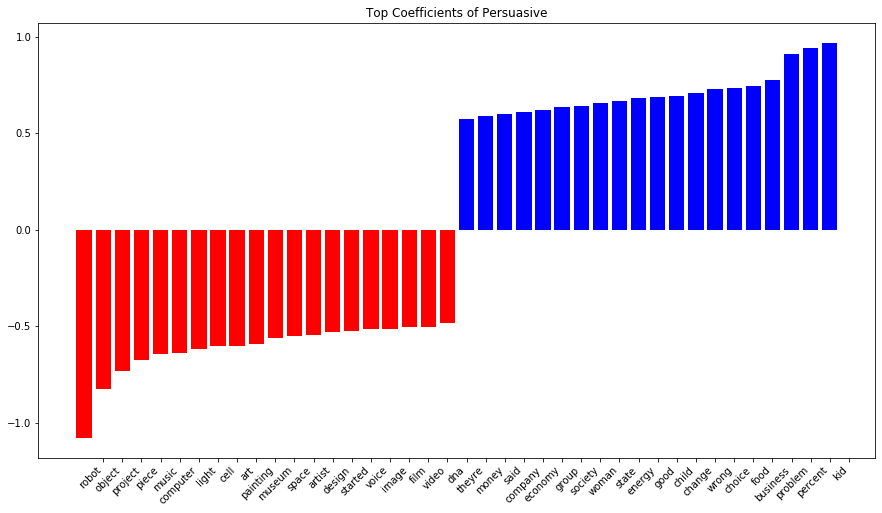

In [88]:
# Instantiate TfidfVectorizer with the best parameters
tvec_final = TfidfVectorizer(min_df=2, max_features=None, max_df=0.7, 
                           stop_words='english', ngram_range=(1,2))
X_train_final = tvec_final.fit_transform(X_train)
X_test_final = tvec_final.transform(X_test)

# Fit SVM model
svm_final = SGDClassifier(tol=0.001, penalty='l2', max_iter=1000, loss='log', 
                          early_stopping=True, alpha=0.001, random_state=42)
svm_final.fit(X_train_final, y_train)

# Plot the coefficients
plot_coefficients(svm_final, tvec_final.get_feature_names())
plt.title('Top Coefficients of Persuasive');

#### Test on Unseen Data

In [89]:
# Get predictions
preds = svm_final.predict(X_test_final)
print('Test set accuracy score: ', accuracy_score(y_test, preds))

Test set accuracy score:  0.5


The accuracy score on unseen data is quite low at 50%. The reason could be that these top 40 speeches focus on other topics, namely politics. The TED Talks data that we have do not contain politics in the top tags as we have seen in the EDA earlier.

In [90]:
model_eval = pd.DataFrame(speeches['title'])
model_eval['speech'] = X_test
model_eval['label'] = y_test
model_eval['predictions'] = preds

In [91]:
# Check dataframe
model_eval.head()

,title,speech,label,predictions
0,I have a dream by MLK,dream one day alabama vicious racist governor lip dripping word interposition nullification one day right alabama little black boy black girl able join hand little white boy white girl sister brother dream today dream one day every valley shall exalted every hill mountain shall made low rough pl...,1,0
1,Tilbury Speech by Queen Elizabeth I,loving people persuaded careful safety take heed commit self armed multitude fear treachery assure desire live distrust faithful loving people let tyrant fear always behaved god placed chiefest strength safeguard loyal heart good subject therefore come amongst see time recreation disport resolve...,1,0
2,"Woodrow Wilson, address to Congress (April",world must made safe democracy peace must planted upon tested foundation political liberty selfish end serve desire conquest dominion seek indemnity material compensation sacrifice shall freely make one champion right mankind shall satisfied right made secure faith freedom nation make fight with...,1,1
3,Ain’t I A Woman by Sojourner Truth,man say woman need helped carriage lifted ditch best place everywhere nobody ever help carriage mud puddle give best place woman look look arm ploughed planted gathered barn man could head woman could work much eat much man could get bear lash well woman borne thirteen child seen sold slavery cr...,1,1
4,The Gettsyburg Address by Abraham Lincoln,fondly hope fervently pray mighty scourge war may speedily pas away yet god will continue wealth piled bondsman two hundred fifty year unrequited toil shall sunk every drop blood drawn lash shall paid another drawn sword said three thousand year ago still must said judgment lord true righteous a...,1,0


In [92]:
# Pick out the incorrectly predicted ones
persuasive_inaccurate = model_eval[model_eval['predictions'] == 0]
persuasive_inaccurate.head()

,title,speech,label,predictions
0,I have a dream by MLK,dream one day alabama vicious racist governor lip dripping word interposition nullification one day right alabama little black boy black girl able join hand little white boy white girl sister brother dream today dream one day every valley shall exalted every hill mountain shall made low rough pl...,1,0
1,Tilbury Speech by Queen Elizabeth I,loving people persuaded careful safety take heed commit self armed multitude fear treachery assure desire live distrust faithful loving people let tyrant fear always behaved god placed chiefest strength safeguard loyal heart good subject therefore come amongst see time recreation disport resolve...,1,0
4,The Gettsyburg Address by Abraham Lincoln,fondly hope fervently pray mighty scourge war may speedily pas away yet god will continue wealth piled bondsman two hundred fifty year unrequited toil shall sunk every drop blood drawn lash shall paid another drawn sword said three thousand year ago still must said judgment lord true righteous a...,1,0
9,The Hypocrisy of American Slavery by Frederick Douglass,american slave fourth july answer day reveals day year gross injustice cruelty constant victim celebration sham boasted liberty unholy license national greatness swelling vanity sound rejoicing empty heartless shout liberty equality hollow mock prayer hymn sermon thanksgiving religious parade so...,1,0
10,Still I Rise by Maya Angelou,may write history bitter twisted lie may trod dirt still like dust rise sassiness upset beset gloom cause walk like got oil well pumping living room like moon like sun certainty tide like hope springing high still rise want see broken bowed head lowered eye shoulder falling like teardrop weakene...,1,0


In [93]:
# Function to TFIDF vectorize and place the count of words into a dataframe
def count_words(data, num):
    
    # Instantiate TFIDF Vectorizer with stopwords to remove them
    tf = TfidfVectorizer(stop_words = 'english')
    # Fit and transform the data with Count Vectorizer
    data_tf = tf.fit_transform(data).todense()
    # Change it into dataframe
    data_tf_df = pd.DataFrame(data_tf, columns = tf.get_feature_names())
    
    # Get a column containing the count of words called total and 
    # create a new dataframe with only the total and word columns
    data_total = pd.DataFrame(data_tf_df.sum(axis=0), columns=['total']).reset_index()
    data_total.rename({'index': 'word'}, axis=1, inplace=True)
    
    # Get the top words in the speeches
    top_data = data_total.sort_values(by='total', ascending=False).head(num)
    return top_data

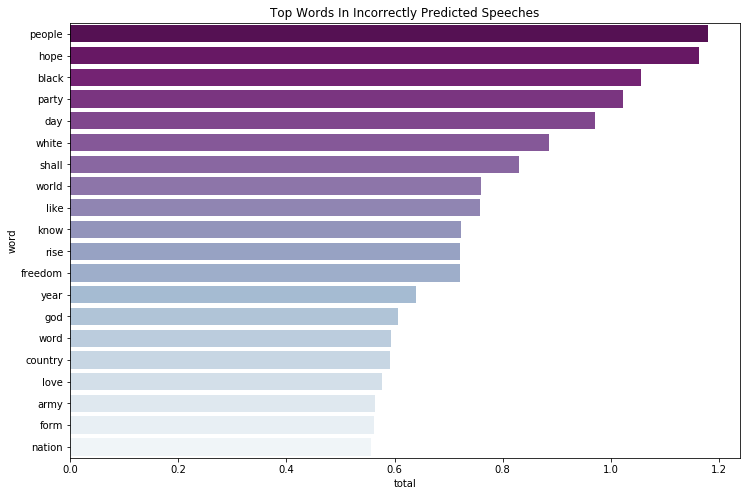

In [94]:
top_persuasive_inaccuracies = count_words(persuasive_inaccurate['speech'],20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_persuasive_inaccuracies, palette='BuPu_r')
plt.title('Top Words In Incorrectly Predicted Speeches');

In [95]:
# Pick out the correctly predicted ones
persuasive_accurate = model_eval[model_eval['predictions'] == 1]
persuasive_accurate.head()

,title,speech,label,predictions
2,"Woodrow Wilson, address to Congress (April",world must made safe democracy peace must planted upon tested foundation political liberty selfish end serve desire conquest dominion seek indemnity material compensation sacrifice shall freely make one champion right mankind shall satisfied right made secure faith freedom nation make fight with...,1,1
3,Ain’t I A Woman by Sojourner Truth,man say woman need helped carriage lifted ditch best place everywhere nobody ever help carriage mud puddle give best place woman look look arm ploughed planted gathered barn man could head woman could work much eat much man could get bear lash well woman borne thirteen child seen sold slavery cr...,1,1
5,Woman’s Rights to the Suffrage by Susan B Anthony,state make sex qualification must ever result disfranchisement one entire half people pas bill attainder ex post facto law therefore violation supreme law land blessing liberty ever withheld woman female posterity government power derived consent governed government democracy republic odious ari...,1,1
6,"Vladimir Lenin’s Speech at an International Meeting in Berne, February",may sound incredible especially swiss comrade nevertheless true russia also bloody tsarism capitalist also section called ex socialist say russia fighting war defence russia fighting german invasion whole world know however decade tsarism oppressing hundred million people belonging nationality r...,1,1
7,I Have A Dream Speech by Mary Wollstonecraft,say would impress declamation reason offer sober light really capable acting like rational creature let treated like slave like brute dependent reason man associate cultivate mind give salutary sublime curb principle let attain conscious dignity feeling dependent god teach common man submit nece...,1,1


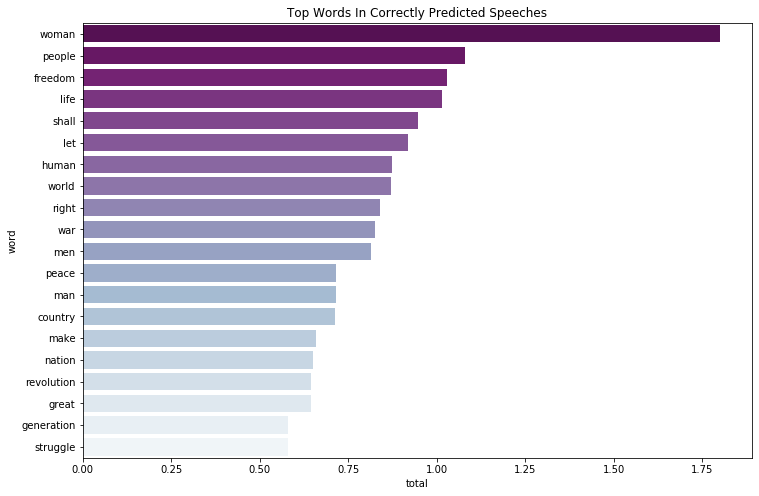

In [96]:
top_persuasive_accuracies = count_words(persuasive_accurate['speech'], 20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_persuasive_accuracies, palette='BuPu_r')
plt.title('Top Words In Correctly Predicted Speeches');

### Inspiring Classifier Evaluation

In [97]:
X_train = ted_model.transcript
y_train = ted_model.inspiring_label

X_test = speeches.speech
y_test = speeches.inspiring_label

In [81]:
# Check the best parameters to instantiate model
inspiring_tuning

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score
0,logreg,"{'tf__min_df': 1, 'tf__max_features': None, 'tf__max_df': 0.8, 'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__max_iter': 100, 'logreg__C': 3.0}",1.00000,0.689702,0.716216,0.681234,0.698287
1,svm,"{'tf__min_df': 2, 'tf__max_features': None, 'tf__max_df': 1.0, 'svm__tol': 0.0001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'hinge', 'svm__early_stopping': False, 'svm__alpha': 0....",0.93434,0.705962,0.654054,0.731118,0.690442


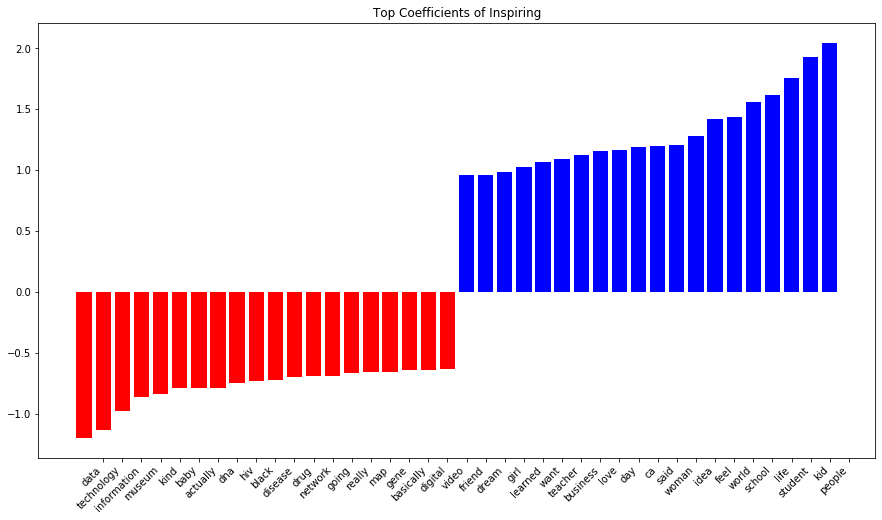

In [98]:
# Instantiate TfidfVectorizer with the best parameters
tvec_final = TfidfVectorizer(min_df=2, max_features=None, max_df=1.0, 
                           stop_words='english', ngram_range=(1,2))
X_train_final = tvec_final.fit_transform(X_train)
X_test_final = tvec_final.transform(X_test)

# Fit SVM model
svm_final = SGDClassifier(tol=0.0001, penalty='l2', max_iter=1000, loss='hinge', 
                          early_stopping=False, alpha=0.001, random_state=42)
svm_final.fit(X_train_final, y_train)

# Plot the coefficients
plot_coefficients(svm_final, tvec_final.get_feature_names())
plt.title('Top Coefficients of Inspiring');

#### Test on Unseen Data

In [99]:
# Get predictions and test set accuracy score
preds = svm_final.predict(X_test_final)
print('Test set accuracy score: ', accuracy_score(y_test, preds))

Test set accuracy score:  0.275


In [100]:
model_eval = pd.DataFrame(speeches['title'])
model_eval['speech'] = X_test
model_eval['label'] = y_test
model_eval['predictions'] = preds

In [101]:
# Check dataframe
model_eval.head()

,title,speech,label,predictions
0,I have a dream by MLK,dream one day alabama vicious racist governor lip dripping word interposition nullification one day right alabama little black boy black girl able join hand little white boy white girl sister brother dream today dream one day every valley shall exalted every hill mountain shall made low rough pl...,1,0
1,Tilbury Speech by Queen Elizabeth I,loving people persuaded careful safety take heed commit self armed multitude fear treachery assure desire live distrust faithful loving people let tyrant fear always behaved god placed chiefest strength safeguard loyal heart good subject therefore come amongst see time recreation disport resolve...,1,0
2,"Woodrow Wilson, address to Congress (April",world must made safe democracy peace must planted upon tested foundation political liberty selfish end serve desire conquest dominion seek indemnity material compensation sacrifice shall freely make one champion right mankind shall satisfied right made secure faith freedom nation make fight with...,1,1
3,Ain’t I A Woman by Sojourner Truth,man say woman need helped carriage lifted ditch best place everywhere nobody ever help carriage mud puddle give best place woman look look arm ploughed planted gathered barn man could head woman could work much eat much man could get bear lash well woman borne thirteen child seen sold slavery cr...,1,1
4,The Gettsyburg Address by Abraham Lincoln,fondly hope fervently pray mighty scourge war may speedily pas away yet god will continue wealth piled bondsman two hundred fifty year unrequited toil shall sunk every drop blood drawn lash shall paid another drawn sword said three thousand year ago still must said judgment lord true righteous a...,1,0


In [102]:
# Pick out the incorrectly predicted ones
inspiring_inaccurate = model_eval[model_eval['predictions'] == 0]
inspiring_inaccurate.head()

,title,speech,label,predictions
0,I have a dream by MLK,dream one day alabama vicious racist governor lip dripping word interposition nullification one day right alabama little black boy black girl able join hand little white boy white girl sister brother dream today dream one day every valley shall exalted every hill mountain shall made low rough pl...,1,0
1,Tilbury Speech by Queen Elizabeth I,loving people persuaded careful safety take heed commit self armed multitude fear treachery assure desire live distrust faithful loving people let tyrant fear always behaved god placed chiefest strength safeguard loyal heart good subject therefore come amongst see time recreation disport resolve...,1,0
4,The Gettsyburg Address by Abraham Lincoln,fondly hope fervently pray mighty scourge war may speedily pas away yet god will continue wealth piled bondsman two hundred fifty year unrequited toil shall sunk every drop blood drawn lash shall paid another drawn sword said three thousand year ago still must said judgment lord true righteous a...,1,0
5,Woman’s Rights to the Suffrage by Susan B Anthony,state make sex qualification must ever result disfranchisement one entire half people pas bill attainder ex post facto law therefore violation supreme law land blessing liberty ever withheld woman female posterity government power derived consent governed government democracy republic odious ari...,1,0
6,"Vladimir Lenin’s Speech at an International Meeting in Berne, February",may sound incredible especially swiss comrade nevertheless true russia also bloody tsarism capitalist also section called ex socialist say russia fighting war defence russia fighting german invasion whole world know however decade tsarism oppressing hundred million people belonging nationality r...,1,0


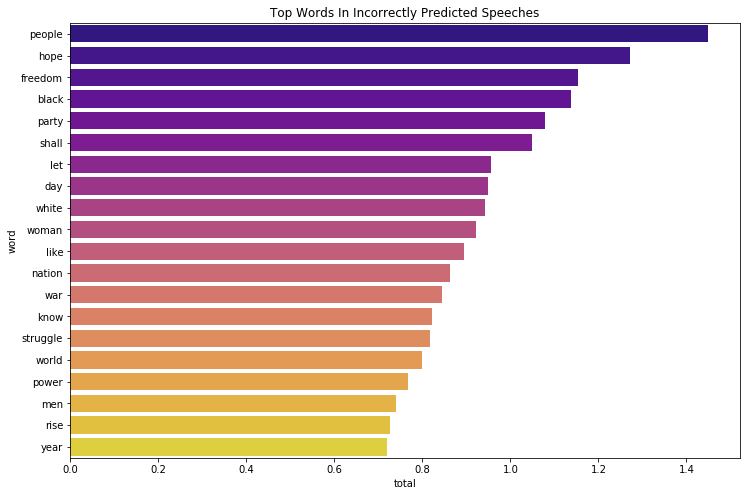

In [106]:
top_inspiring_inaccuracies = count_words(inspiring_inaccurate['speech'],20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_inspiring_inaccuracies, palette='plasma')
plt.title('Top Words In Incorrectly Predicted Speeches');

In [104]:
# Pick out the correctly predicted ones
inspiring_accurate = model_eval[model_eval['predictions'] == 1]
inspiring_accurate.head()

,title,speech,label,predictions
2,"Woodrow Wilson, address to Congress (April",world must made safe democracy peace must planted upon tested foundation political liberty selfish end serve desire conquest dominion seek indemnity material compensation sacrifice shall freely make one champion right mankind shall satisfied right made secure faith freedom nation make fight with...,1,1
3,Ain’t I A Woman by Sojourner Truth,man say woman need helped carriage lifted ditch best place everywhere nobody ever help carriage mud puddle give best place woman look look arm ploughed planted gathered barn man could head woman could work much eat much man could get bear lash well woman borne thirteen child seen sold slavery cr...,1,1
13,Inaugural Address by John F Kennedy,long history world generation granted role defending freedom hour maximum danger shrink responsibility welcome believe u would exchange place people generation energy faith devotion bring endeavor light country serve glow fire truly light world fellow american ask country ask country fellow citi...,1,1
14,Atoms for Peace Speech by Dwight Eisenhower,pause would confirm hopeless finality belief two atomic colossus doomed malevolently eye indefinitely across trembling world stop would accept helplessly probability civilization destroyed annihilation irreplaceable heritage mankind handed u generation generation condemnation mankind begin age o...,1,1
19,Nobel Lecture by Mother Teresa,believe real social worker may social work eye people really contemplative heart world touching body christ 24 hour 24 hour presence try bring presence god family family prays together stay together think family need bomb gun destroy bring peace get together love one another bring peace joy stre...,1,1


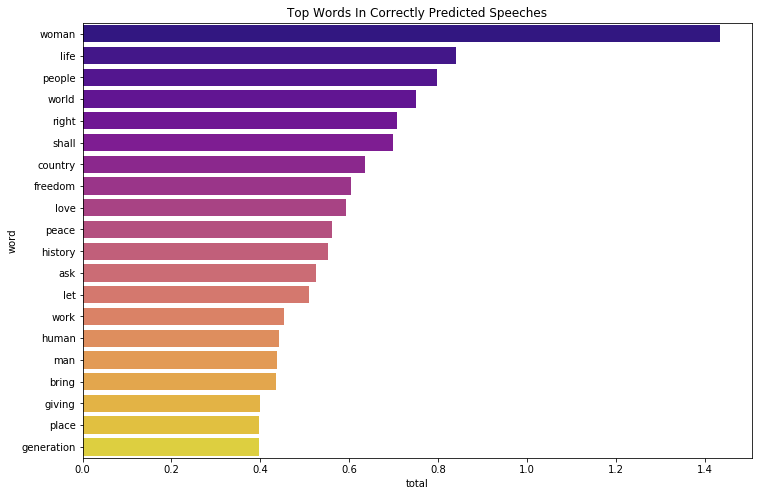

In [107]:
top_inspiring_accuracies = count_words(inspiring_accurate['speech'], 20)
plt.figure(figsize=(12,8))
sns.barplot(x='total', y='word', data=top_inspiring_accuracies, palette='plasma')
plt.title('Top Words In Correctly Predicted Speeches');

### Unconvincing Classifier Evaluation

For this classifier, we will evaluate it using our original dataset with train/ test split and see the accuracy of the prediction on the test set.

In [108]:
X_train = ted_model.transcript
y_train = ted_model.unconvincing_label

In [109]:
# Check the best parameters to instantiate model
unconvincing_tuning

,model,best_params,train_accuracy,test_accuracy,recall,precision,f1-score
0,svm,"{'tf__min_df': 2, 'tf__max_features': 1000, 'tf__max_df': 0.75, 'svm__tol': 0.0001, 'svm__penalty': 'l2', 'svm__max_iter': 1000, 'svm__loss': 'hinge', 'svm__early_stopping': True, 'svm__alpha': 0.001}",0.801859,0.680217,0.710875,0.678481,0.694301
1,logreg,"{'tf__min_df': 1, 'tf__max_features': None, 'tf__max_df': 0.8, 'logreg__solver': 'liblinear', 'logreg__penalty': 'l2', 'logreg__max_iter': 100, 'logreg__C': 2.0}",1.000000,0.666667,0.838196,0.630739,0.719818


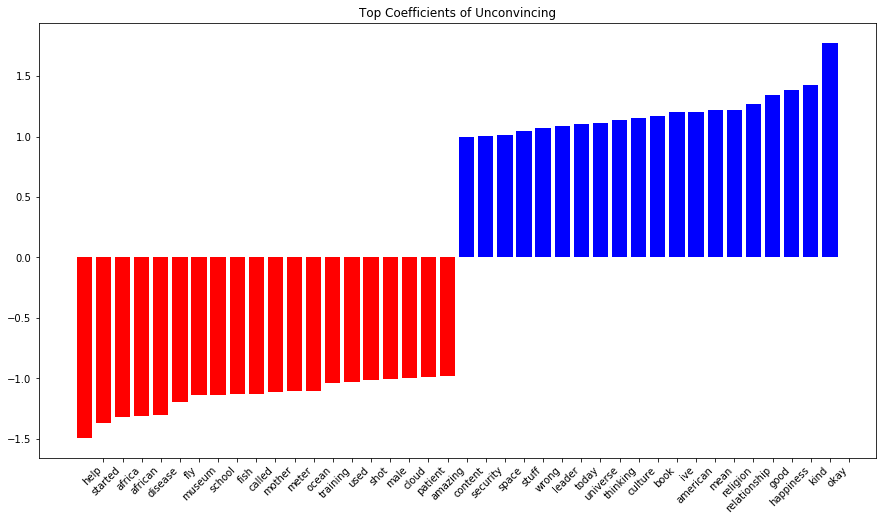

In [111]:
# Instantiate TfidfVectorizer with the best parameters
tvec_final = TfidfVectorizer(min_df=2, max_features=1000, max_df=0.75, 
                           stop_words='english', ngram_range=(1,2))
X_train_final = tvec_final.fit_transform(X_train)
X_test_final = tvec_final.transform(X_test)

# Fit SVM model
svm_final = SGDClassifier(tol=0.0001, penalty='l2', max_iter=1000, loss='hinge', 
                          early_stopping=True, alpha=0.001, random_state=42)
svm_final.fit(X_train_final, y_train)

# Plot the coefficients
plot_coefficients(svm_final, tvec_final.get_feature_names())
plt.title('Top Coefficients of Unconvincing');

## Multilabel Classification

Multilabel classification is a problem where multiple target labels can be assigned to each observation instead of only one. This is the exact situation we are facing now with more than one label assigned to some of the talks. 

For this problem, the models that will be run are Naive Bayes and Support Vector Machine with OneVsRest wrapper that can be used for multilabel learning.

### Train/Test Split

In [20]:
labels = ['persuasive_label', 'inspiring_label', 'unconvincing_label']

train, test = train_test_split(ted_model, random_state=42, test_size=0.33, shuffle=True)
X_train = train.transcript
X_test = test.transcript
print('Training data shape:', X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1647,)
Testing data shape: (812,)


### Linear SVC

In [22]:
svc_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=100, C=0.1), n_jobs=-1)),
            ])

for label in labels:
    print('Processing {}'.format(label))
    
    # train the model using X_train and y_train
    svc_pipeline.fit(X_train, train[label])

    # compute training accuracy
    train_pred = svc_pipeline.predict(X_train)
    print('Train accuracy: {}'.format(accuracy_score(train[label], train_pred)))
    
    # compute testing accuracy
    test_pred = svc_pipeline.predict(X_test)
    print('Test accuracy: {}'.format(accuracy_score(test[label], test_pred)))

Processing persuasive_label
Train accuracy: 0.9477838494231937
Test accuracy: 0.6921182266009852
Processing inspiring_label
Train accuracy: 0.9629629629629629
Test accuracy: 0.6736453201970444
Processing unconvincing_label
Train accuracy: 0.9690346083788707
Test accuracy: 0.6945812807881774


This multilabel classifier is very overfit but the test accuracy is quite high.

### Naive Bayes

In [138]:
nb_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))
])

for label in labels:
    print('Processing {}'.format(label))
    # train the model using X_train and y_train
    nb_pipeline.fit(X_train, train[label])
    
    # compute training accuracy
    train_pred = nb_pipeline.predict(X_train)
    print('Train accuracy: {}'.format(accuracy_score(train[label], train_pred)))
    
    # compute testing accuracy
    test_pred = nb_pipeline.predict(X_test)
    print('Test accuracy: {}'.format(accuracy_score(test[label], test_pred)))

Processing persuasive_label
Train accuracy: 0.8597449908925319
Test accuracy: 0.5394088669950738
Processing inspiring_label
Train accuracy: 0.9077109896782027
Test accuracy: 0.541871921182266
Processing unconvincing_label
Train accuracy: 0.9738919247115968
Test accuracy: 0.6514778325123153


The test accuracy for Naive Bayes is lower than that of SVC.

### Logistic Regression

In [21]:
logreg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag', C=0.1), n_jobs=-1)),
            ])
for label in labels:
    print('Processing {}'.format(label))
    # train the model using X_train and y_train
    logreg_pipeline.fit(X_train, train[label])
    # compute training accuracy
    train_pred = logreg_pipeline.predict(X_train)
    print('Train accuracy: {}'.format(accuracy_score(train[label], train_pred)))
    # compute testing accuracy
    test_pred = logreg_pipeline.predict(X_test)
    print('Test accuracy: {}'.format(accuracy_score(test[label], test_pred)))

Processing persuasive_label
Train accuracy: 0.8384942319368549
Test accuracy: 0.6490147783251231
Processing inspiring_label
Train accuracy: 0.8324225865209471
Test accuracy: 0.5825123152709359
Processing unconvincing_label
Train accuracy: 0.8907103825136612
Test accuracy: 0.6613300492610837


The test accuracy of Logistic Regression is lower than SVC's but the model is less overfit than SVC. So, we will compare the two models using unseen data.

#### Test on Unseen Data

In [23]:
labels = ['persuasive_label','inspiring_label']

# Set the TEDTalks transcripts as the training set and the speeches as the test set
X_train = ted_model.transcript
X_test = speeches.speech

In [25]:
# Test Logistic Regression model on unseen data
logreg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag', C=0.1), n_jobs=-1)),
            ])

for label in labels:
    print('Processing {}'.format(label))
    # train the model using X_train and y_train
    logreg_pipeline.fit(X_train, ted_model[label])
    
    # compute predictions
    test_pred = logreg_pipeline.predict(X_test)
    print('Test accuracy: {}'.format(accuracy_score(speeches[label], test_pred)))

Processing persuasive_label
Test accuracy: 0.25
Processing inspiring_label
Test accuracy: 0.4


In [24]:
# Test SVC on unseen data
svc_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=100, C=0.1), n_jobs=-1)),
            ])

for label in labels:
    print('Processing {}'.format(label))
    # train the model using X_train and y_train
    svc_pipeline.fit(X_train, ted_model[label])
    
    # compute predictions
    test_pred = svc_pipeline.predict(X_test)
    print('Test accuracy: {}'.format(accuracy_score(speeches[label], test_pred)))

Processing persuasive_label
Test accuracy: 0.275
Processing inspiring_label
Test accuracy: 0.4


In [ ]:
# Compute predictions for all three labels
test_pred = svc_pipeline.predict(X_test)
print('Test accuracy: {}'.format(accuracy_score(speeches[label], test_pred)))

Logistic regression performed better here perhaps because it is more generalisable. Compared to the binary classifiers, the persuasive binary classifier performed better than the multilabel Logistic regression while the inspiring binary classifier performed worse. 

The Logistic Regression multilabel classifier will be deployed as the production model because it is still less overfitted compared to the other models.

## Conclusion

### Production Model

The production model is the **TfidfVectorizer Logistic Regression with OneVsRestClassifier** with the following parameters:
* stop_words = 'english'
* ngram_range = (1,2)
* solver = 'sag'
* C = 0.1

The reason for the model's poor performance against the unseen data chosen could be the different context and words used in TEDTalks as opposed to the top 40 most inspiring speeches of all time, which tend to be political in nature.

Even though the performance against the unseen data was not satisfactory, the model beat the baseline score and is one of the better ones in generalising to unseen data.

### Top Coefficients

What we can glean from the binary classification models are the top coefficients:

**1. Persuasive words:**
    * kid
    * percent
    * problem
    * business
    * food

The tags that come up most frequently for persuasive talks are global issues, culture and business so it is no surprise that the words related to global issues (e.g. problem) and business (e.g. percent, business) and culture (e.g. food) have made it to the top positive coefficients in persuasive talks.

**2. Inspiring words:**
    * people
    * kid
    * student
    * life
    * school

The top inspiring words seem to be mainly focussed on education and we saw that educator is one of the top professions with talks voted inspiring. 

**3. Unconvincing words:**
    * okay
    * kind
    * happiness
    * good
    * relationship

The top unconvincing word is okay, which may suggest that a neutral word like 'okay' does not leave much of an impression on the audience.

### Limitations

1. TEDTalks can have a wide focus, so in order to deploy it for the purpose of making business presentations/pitches more persuasive, we require more specific data on businesses in different industries because they have different jargons that can be useful to be learned by the model.


2. There could be other predictors of persuasiveness apart from what is captured in the transcripts. Examples include:
    * **Currency of topics of speech**: As we have seen in the top 40 speeches, they include speeches by Martin Luther King, Nelson Mandela and the likes. The political context plays a large role in persuasion and inspiration because it is already a topic most people feel strongly about at that point in time.
    * **Profession**: We saw in the earlier EDA that different careers are associated with being persuasive/ inspiring (authors, economists, activists, educators) and unconvincing (artists, inventors, designers). Given that the tags/ topics associated with all three talks are roughly the same, the difference could come either in either the words they use or the way the words are phrased. Those who are unconvincing tend to be from creative professions, which perhaps do not require much word exchanges at work. 
    * Other predictors could be **tone, gender, duration of talk**, etc.


3. We could also tweak the use of data. In this project, the label of 1 are given when a talk receives more than the median number of votes for that particular category (i.e. if talk 1 has x number of votes on unconvincing, which is higher than the median number of votes for unconvincing, it will be labeled as unconvincing). While this ensures that each class is balanced, it does not help with the fact that there are actually many more votes for inspiring and persuasive compared to unconvincing. So the model could be less accurate for unconvincing class because it is easier for a talk to qualify as being unconvincing than inspiring or persuasive. 

### Future Works

The limitations in the data used can be addressed in future works. The deployability depends on the industry. If the model were to be deployed in technology-related industry, speeches could be filtered based on tags and the model could be trained only on technology-related talks. For higher accuracy, better data such as pitches or presentations made in business meetings could be used instead. 